In [67]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [68]:
x_train_dir = "train_images"
y_train_dir = "train_labels"

x_valid_dir = "valid_images"
y_valid_dir = "valid_labels"

In [69]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [70]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [71]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ["_background_", "foam"]
    COLOURS = [0, 38]

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id[:len(image_id)-4]+".png") for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.COLOURS[self.CLASSES.index(cls.lower())] for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

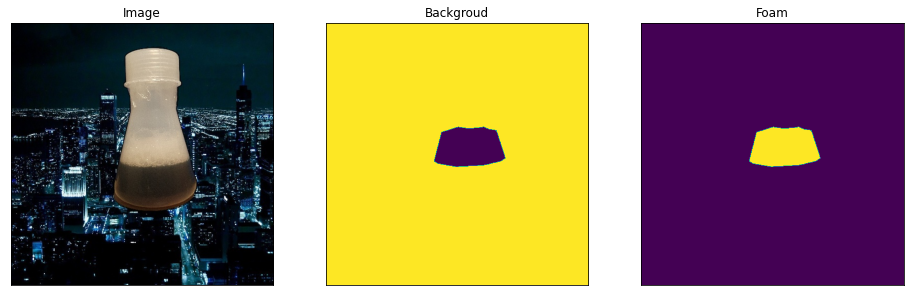

In [72]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=["_background_", "foam"])

image, mask = dataset[0] # get some sample

visualize(
    image=image, 
    backgroud = mask[:,:,0].squeeze(),
    foam = mask[:,:,1].squeeze(),
)

In [73]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        # albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        # albu.OneOf(
        #     [
        #         albu.CLAHE(p=1),
        #         albu.RandomBrightness(p=1),
        #         albu.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),

        # albu.OneOf(
        #     [
        #         albu.IAASharpen(p=1),
        #         albu.Blur(blur_limit=3, p=1),
        #         albu.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

        # albu.OneOf(
        #     [
        #         albu.RandomContrast(p=1),
        #         albu.HueSaturationValue(p=1),
        #     ],
        #     p=0.9,
        # ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

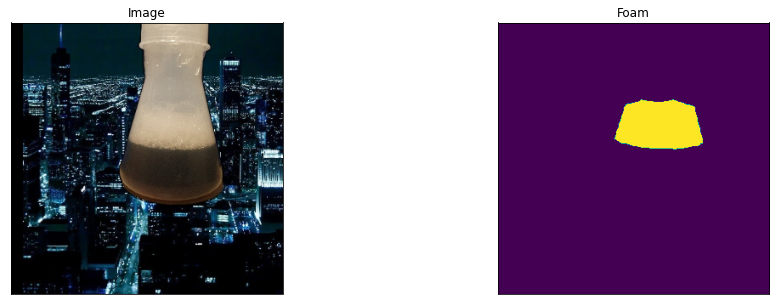

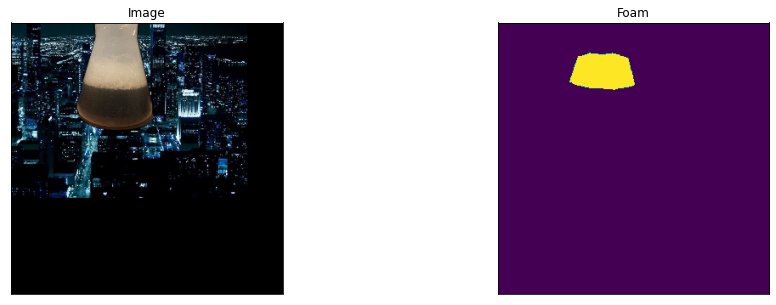

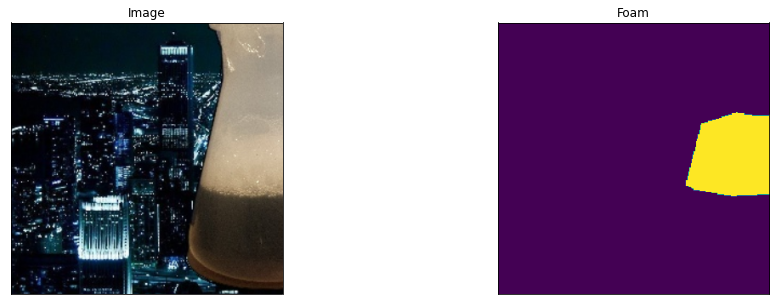

In [74]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=["foam"],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[0]
    visualize(
    image=image,     
    foam = mask[:,:,0].squeeze(),
    )

In [75]:
import torch
import numpy as np
import segmentation_models_pytorch_local as smp

In [76]:
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

In [77]:
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["foam"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [78]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False, num_workers=0)

In [79]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

In [80]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [81]:

train_loss_logger = []
train_score_logger = []
valid_loss_logger = []
valid_score_logger = []

In [82]:
# train model for 40 epochs
max_score = 0
num_epochs = 1
for i in range(0, num_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    train_loss_logger.append(train_logs['dice_loss'])
    train_score_logger.append(train_logs['iou_score'])
    valid_loss_logger.append(valid_logs['dice_loss'])
    valid_score_logger.append(valid_logs['iou_score'])


    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'Models/foam_model_test.pth')
        print('Model saved!')
        
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
valid: 100%|██████████| 53/53 [00:32<00:00,  1.65it/s, dice_loss - 0.9245, iou_score - 0.5674]
Model saved!


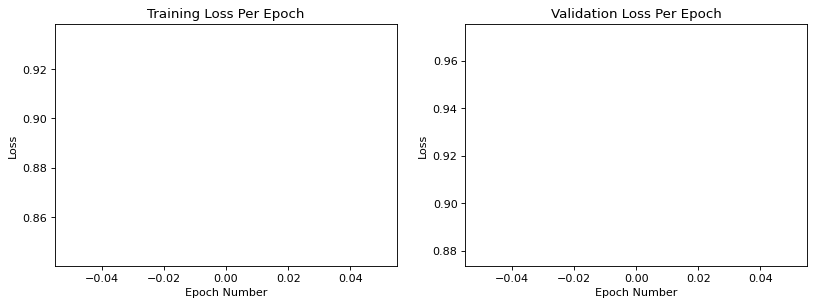

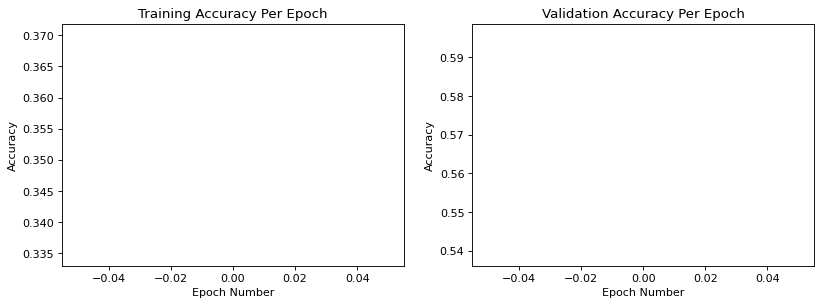

In [83]:
from utils.visualisation import plotting

plotting(num_epochs, train_loss_logger, train_score_logger, valid_loss_logger, valid_score_logger)

In [88]:
model = torch.load("Models/foam_model_test.pth")

img = cv2.imread("images/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1024, 1024), interpolation=cv2.INTER_CUBIC)
img_tensor = torch.unsqueeze(torch.moveaxis(torch.from_numpy(img), 2,0), dim=0).float().to(device)

output = model(img_tensor)
output = torch.moveaxis(torch.squeeze(output, dim=0), 0, 2).cpu().detach().numpy()

# background, foam = [output[:,:, 0], output[:,:, 1]]
foam = output[:,:, 0]
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 60))

ax[0].imshow(img)
ax[0].axis("off")
ax[1].imshow(foam)
ax[1].axis("off")
# ax[2].imshow(foam)
# ax[2].axis("off")


RuntimeError: Wrong input shape height=3024, width=3024. Expected image height and width divisible by 32. Consider pad your images to shape (3040, 3040).